# Lab 4:  Decision Tree, Bagging, and Random Forests


Decision trees, bagging, and random forecasts can be used for either regression or classification tasks. Decision trees are a powerful tool; however, are very prone to overfitting the training dataset and therefore often fail to generalize well to test data sets.  To overcome Decisions Trees tendancy to overfit, one can aggregate the results from many decision trees with an [enesemble approach](http://scikit-learn.org/stable/modules/ensemble.html). In this lesson we will focus on Random Forests, which prevent overfitting by only allowing a given decision tree to optimize for a random subset of the data for every tree, and a random subset of the input features at every split (Don't worry, much more to come :) ). 


<img src="../../images/DecisionTreeExample.png" alt="Drawing" style="width: 500px;height=500"/>

A quick refresher on Bagging:
- Grow multiple decisions trees from random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!

Here's a look ahead at what we'll be doing in this notebook:


1. [Load data and packages](#loaddata)   
  1.1 Load python packages  
  1.2 Set jupyter notebook preferences  
  1.3 Load Data
    
Then we will work incrementally from Decision Trees to Random Forests. At each stage we will experiment with tuning the model parameters and evaluate the models performance.
2. [Build Decision Tree](#decisiontree)

3. [Build Bagged Decision Tree](#bagging)

4. [Build Random Forest](#randomforest)

5. [Feature Importance](#featureimportance)

As a reminder our previous model, Linear regression, was a parametric model with assumes linearity among others. Whereas decision trees and associated algorithms are non-parametric models which means we are no longer restricted to independant variables which have a linear relationship and we don't have to ensure several assumptions are true. 

Therefore we can start to bring in other features that could be useful.

After we run our decision trees, we will compare our new output to our output from the linear regressions we ran in the previous notebook. 

In this notebook, we will be looking at how we can predict the loan amount using decision trees, bagged decisions trees and the random forest algorithm. However, it is worth mentioning that these methods can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

## 1. Import packages
<a id='loaddata'></a>

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ggplot import *
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import graphviz 
from sklearn import tree

If you don't have graphviz installed or are having problems displaying the tree structure later on, try:
- brew install graphviz (Mac/Windows)
- sudo apt-get install graphviz (Linux)

In [2]:
# Load data to pandas DataFrame
data_path = '../data/'
df = pd.read_csv(data_path+'df_end_of_linear.csv', low_memory=False)

In [119]:
# TODO: Remove this part and incorporate it into feature engineering section.
# potentially the feature engineering section should show how to do one hot encoding and this module
# will reference one hot encoding and remove any cols that are strings to highligh that sklearn's implementation
# cannot handle strings.
df = df.dropna()
cols = df[['loan_amount', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'female',
           'num_tags',
           'parent',
           'tag_#Woman Owned Biz',
           'age_int',
           'tag_#Repeat Borrower',
           'children_int',
          'more_one_partner_country',
          'terms.repayment_term',
           'tag_#Schooling',
           'married',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'num_partner_countries',
           'days_to_fund',
            'hours_to_fund',
            'bc_partner_others',
           'bc_partner_HIHEA',
           'bc_partner_OAF_high',
           'bc_partner_OAF_low',
         'sector_Personal Use',
           'sector_Health',
           'sector_Wholesale',
           'sector_Agriculture',
           'kids']]


Just like last module, we are going to build regressors to predict the loan amount.

However, instead of using just a few features, we are going to initially build a tree that considers many the features in the dataset - including those we have engineered ourselves.

In [120]:
y = df['loan_amount']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('loan_amount', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Decision Tree
<a id='decisiontree'></a>
Before we build our first decision tree, let's first learn about the input parameters for sklearn's implementation of a Decision Tree Regressor.  Feel free to look at the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.get_params), or simply put a question mark before a call to the class.  Prepending a ? to any method, variable, or class will display that method's defined docstring (way to go ipython!)

In [49]:
?DecisionTreeRegressor

Many of the sklearn algorithms are implemented using the same standard steps: 
- **Step 1: Initiate the algorithm** This is where we define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, this is where we would define the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 

- **Step 2: Train the algorithm** This is where we train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** This is where we evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

First let build a function which encapsulates the 3 model implementation steps; Initialize, Train, Evaluate for any given sklearn regressor. 

We've included an option to calculate the 'Out Of Bag Score' - remember this from the lectures? This is an average of the model performance on Out Of Bag data during bagging. If this doesn't sound familiar, check out this blog to refresh your memory on [bagging and ensemble methods](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/). 

We will also discuss this further below in the [bagging](#bagging) section of this notebook

In [36]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters,print_oob_score=False):
    '''
    Purpose: 
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    '''
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    # Print the results!
    print("Train score: " + str(training_score))
    print("Test score: " + str(testing_score))
    if print_oob_score:
        print("OOB score: " + str(regressor.oob_score_))
        
    return regressor
?train_score_regressor

With all tree algorithms the major challenge is using the parameters to balance the bias vs variance tradeoff.  Before we get into exploring the parameters, let's see how the model preforms while using the default values.

In [37]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {'random_state':42})

Train score: 1.0
Test score: 0.337401966989


While the Decision Tree managed to get a perfect r2 scored on the training data, it managed an abysmal .34 on the test data.  This is a clear indication that the model has overfit the data.  Given that by default sklearn's implementation of a DecisionTreeRegressor does not put any restrictions on the depth of the tree, the number of samples per leaf, the number of samples per leaf, etc.  As a result, the Decision Tree will find signal in any and all noise of the training data set, which causes the model to perform poorly on the test data.  When a model overfits to a training data set, we say it has **high variance**.  Since an unconstrained decision tree will almost perfectly model any training data, it will vary tremendously depending on the training data that is provided.

### Parameter tuning
To reduce the variance, let's now try to constrain the model using some of the provided parameters. Some of the main parameters that can be tuned are:
- Criterion
- Maximum depth of the tree
- Minimum samples for each node split
- Minimum samples for each terminal node
- Maximum number of terminal nodes

If you need a refresher to remember what these parameters are, look back over the class notes or use this [useful blog](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/#four).

Initially, we are going to experiment with the max_depth parameter. 

In [50]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"max_depth":4,'random_state':42})

Train score: 0.558032781957
Test score: 0.438339906714


Although the training r2 score plummeted down to .54, the test r2 score increased to .44, and since the goal is develop a model that accurately predict data we have never seen, that is the data we care about!

Now that we have increased preformance, let's take a look at what the Decision Tree looks like.

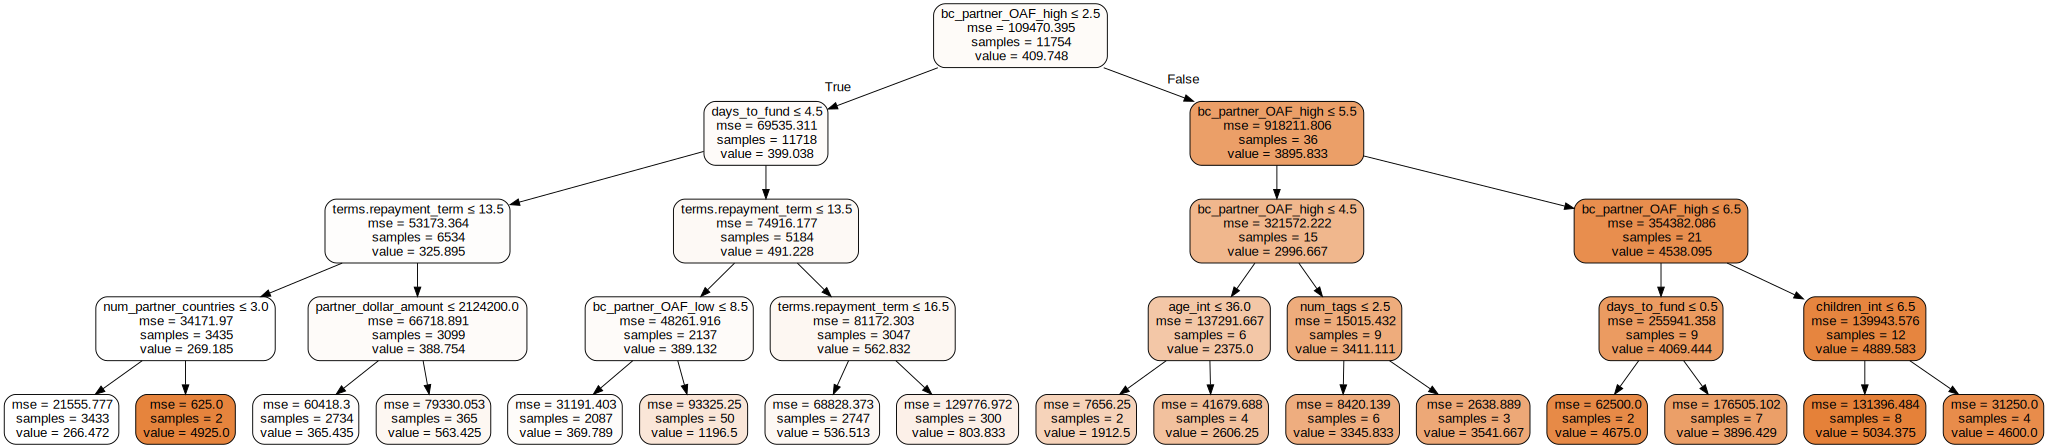

In [51]:
dot_data = tree.export_graphviz(trained_regressor, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=y_train.values,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

As you can see, even a DecisionTreeRegressor with a max depth of 4 is rather complicated.  To develop your intuition for the various input parameters, I recommend manually adjusting them up and down to see the impacts.

If you were to tune the parameters manually and see how it impacts the training and test data sets that we created above, you would slowly tune towards a higher score on the test data set; however, you would most likely be overfitting to the test data set and the model would not generalize well to a secondary test data set.  To avoid this, it is recommended that you use [k-fold](https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/) validation.

In addition to k-fold validation, we wil use sklearn's GridSearchCV, which allows us using k-fold validation to assess every permuation of possible values for the parameters that we provide. See the [Advanced Material](#AdvancedCV) at the bottom of this notebook for a quick overview of these two methods.

**Note** since we are training one regressor one time for each possible permutation of specified parameter values, this next cell will take some time to run.  That is why you need to gain an intuition for which values to test!

In [65]:
parameters = {'max_depth':[8,10,14], 
              'min_impurity_decrease': [.1,.01, 0.0],
              'min_samples_split': [10, 50, 2]}
decision_regressor= DecisionTreeRegressor()
regressor = GridSearchCV(decision_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [10, 50, 2], 'min_impurity_decrease': [0.1, 0.01, 0.0], 'max_depth': [8, 10, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
# Now that we have finished up training lets print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'criterion': 'mse',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.01,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

Now lets see what happens when we train a DecisionTreeRegressor using these parameters on our original training and test data.

In [67]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = regressor.best_estimator_.get_params())

Train score: 0.693914310997
Test score: 0.566599964277


Performance on the test data has increased from 0.43 to 0.56 - not bad!

The R^2 number above is pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

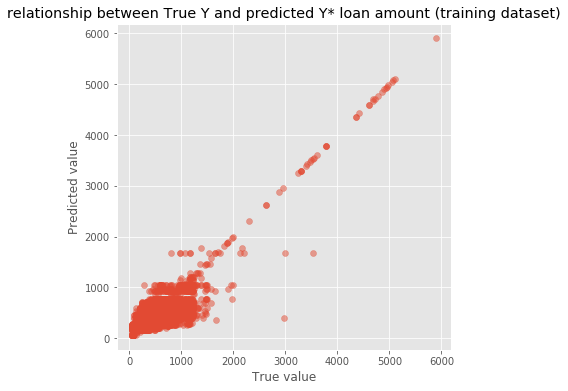

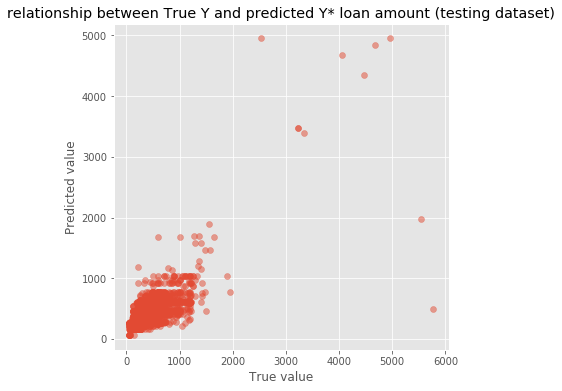

In [44]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title("relationship between True Y and predicted Y* loan amount ({0} dataset)".format(train_test))
    plt.show()
    
plot_y_yhat_scatter(y_train, regressor.predict(X_train),train_test = "training")
plot_y_yhat_scatter(y_test, regressor.predict(X_test),train_test = "testing")


## 3. Bagging
<a id='bagging'></a>

As we just saw, Decision Trees naturally overfit to the data.  One approach to addressing this is by parameter tuning for an individual tree as we did above with the GridSearchCV algorithm. However, better perforamnce is generally achieved when an **ensemble approach** such as bagging is used.

To start with Bagging is a shorter term for Bootstrapping Aggregation which is a general procedure to reduce variance in model that have a tendancy to overfit. Again, here is a [great blog](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) going into more detail if you need to refresh your memory. This diagram below is taken from the website to give a visual overview of how bagging work in the context of a classifying algorithm.

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/09/bagging.png",width=500,height=500>

In the context of the decision tree, a bagging decision tree regressor does the following:
- Creates N random subsample of the dataset using selection with replacement. (Statistically 1/3 of the data is left of each subsample)
- Trains a new decision tree on each N subsample
- Takes the prediction from each and every N tree and averages the result
- This average is the final output of the bagging model. 
This is an **Ensemble approach** where we use the results of several random analyses to find an average response.

Furthermore, for each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or oob_score). This score evaluates the performance of the model on the sample not used while training an individual tree. (Remember a random ~1/3 of data are not used to train a given tree).

Now let's try this out!

In [45]:
# Step 1: Initiating the bagging regressor algorithm
trained_regressor = train_score_regressor(sklearn_regressor = BaggingRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, 'random_state':42},print_oob_score=True)

Train score: 0.93851641227
Test score: 0.596461918366
OOB score: 0.528844447822


/home/rosina/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


The above results are very encouraging. Prior to any parameter tuning, the model is already preforming better on the test data set moving from 0.56 to 0.59. Also we now have access to the oob_score which also indicates how the model performs on unseen data. 

Therefore, when comparing different bagged regression models, we should looking at three main outputs:
- Train score = R^2 between the predicte and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = the error rate of predicted values for data not used whilst training an individual tree

### Changing some model parameters

The default number of trees used in the bagging regressor is 10. This means that the algorithms splits the dataset into 10 different tress, trains each one individually, predicts the result from each one individually and then averages the result. 

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [47]:
trained_regressor = train_score_regressor(sklearn_regressor = BaggingRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 100,'random_state': 42},
                                          print_oob_score=True)

Train score: 0.956238336187
Test score: 0.61044406365
OOB score: 0.68432907825


Here we see an improvement in all scores and in particular the oob_score. This is telling us that splitting the dataset into more tree leads to a more accurate average predicton of the loan_amount on unseen data - exactly what we are after!

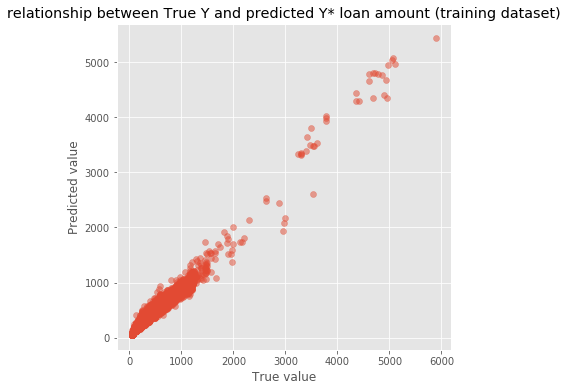

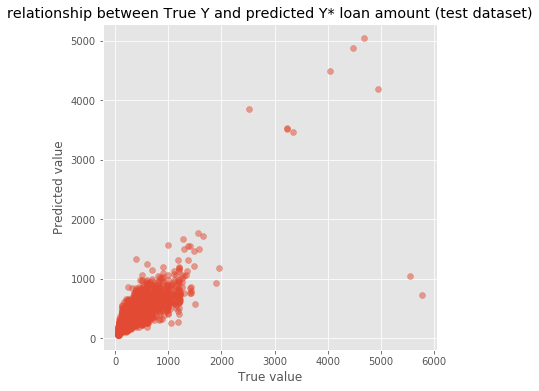

In [48]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
# plotting a graph of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

## Random Forest
<a id='randomforest'></a>

We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated, meaning that given subsets of the same data, the trees are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we can use a Random Forest Regressor, which at each split, only considers a random subsample of the features! This means that the trees are forced to make different split decisions. 

**The main difference between Bagged Decision Trees and Random Forest is that in the Random Forest only considers a random subset of the features at each split**

In [139]:
# Check how many columns our dataset has...
print 'number of features = {}'.format(X_train.shape[1])
num_features = X_train.shape[1]

number of features = 30


Now lets restrict the numbers that the trees can choose from at each split.

In [143]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 100, 
                                                              "max_features": num_features/2, 'random_state':42},
                                          print_oob_score=True)

Train score: 0.95731234318
Test score: 0.62456832897
OOB score: 0.690620824219


We can see that the random forest algorithm has only  slightly improved the performance relative to the bagging regressor. This indicates that the features we are using are already highly uncorrelated.

Let's consider some other hyperparameters. We can set the max_depth to 15 to improve upon overfitting, increase the number of trees and limited the maximum number of features.

In [144]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 300,
                                                              'random_state':42, 'max_depth':15,
                                                              'max_features': 15},
                                          print_oob_score=True)


Train score: 0.89182722835
Test score: 0.627874716257
OOB score: 0.696159909357


Here we see that the oob_score has increased slightly - this is what we expect given that the number of estimators (trees) has increased. In general, increasing the number of trees increases performance until it plateaus. 

Let's see this is action:

In [114]:
num_trees = [100,200,300,400,500,600,700,800]
scores = np.zeros(len(num_trees))
params = {'max_depth': 15,
 'max_features': 15,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 10}
for i in range(len(num_trees)):
    rf_regressor = RandomForestRegressor(n_estimators=num_trees[i],max_depth= 15, max_features= 15, n_jobs= -1,
                                         oob_score= True,random_state= 42)
    rf_regressor.fit(X_train, y_train)
    scores[i] = rf_regressor.oob_score_
    

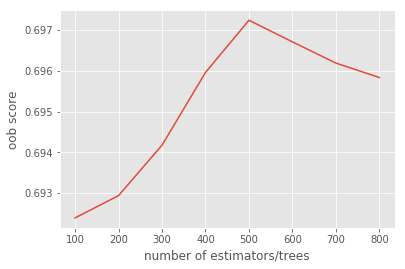

In [115]:
plt.plot(num_trees, scores)
plt.ylabel('oob score')
plt.xlabel('number of estimators/trees')
plt.show()

Again, how do we know the best combination of hyperparameters? Cross validated Grid Search! Let's try it out with our random forest algorithm -  we'll just search over a small range to same time but usually we would search over a bigger range of hyperparameters. 

In [111]:
parameters = {'max_depth':[7,10,15], 
              'max_features': ['sqrt', 15],
              'n_estimators': [300,400]}
rf_regressor= RandomForestRegressor(n_jobs=-1, random_state=42)
regressor = GridSearchCV(rf_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 15], 'n_estimators': [300, 400], 'max_depth': [7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
# Now that we have finished up training lets print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [122]:
params = regressor.best_estimator_.get_params()
params['oob_score'] = True
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = params,
                                          print_oob_score=True)


Train score: 0.892167384971
Test score: 0.628993227049
OOB score: 0.697000294409


Finally lets see how the predicted values compare to the measured values...

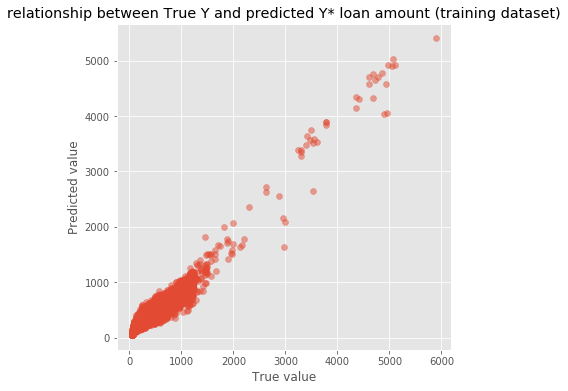

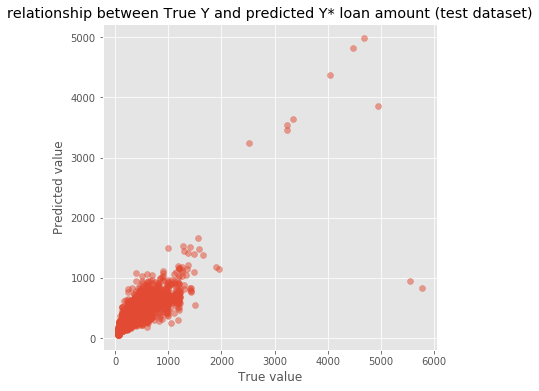

In [123]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
# plotting a graph of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

## 4. Feature Importance

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature. This is known as feature importance. An important but counter-intuitive thing to note here is that the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

Then all we can take away is that feature A is more explains more variance then feautre B, **not** that feature A explains twice as much as feature B. 

Let's look at this for our model...

In [124]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_
# The feature importances are given in the order the features are given in the dataset
# Lets find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]
# Print the important features in descending order
print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature bc_partner_OAF_high (0.267967)
2. feature partner_dollar_amount (0.125181)
3. feature terms.repayment_term (0.120366)
4. feature days_to_fund (0.099548)
5. feature posted_month (0.046314)
6. feature hours_to_fund (0.037882)
7. feature age_int (0.035419)
8. feature posted_year (0.033316)
9. feature partner_delinquency_rate (0.030552)
10. feature num_partner_countries (0.022978)
11. feature bc_partner_OAF_low (0.022031)
12. feature children_int (0.020801)
13. feature top_partner_id (0.020744)
14. feature more_one_partner_country (0.017482)
15. feature num_tags (0.013923)
16. feature exploratory_partner (0.013484)
17. feature bc_partner_HIHEA (0.013374)
18. feature pct_female (0.010181)
19. feature sector_Agriculture (0.009196)
20. feature married (0.006112)
21. feature tag_#Repeat Borrower (0.006002)
22. feature bc_partner_others (0.005576)
23. feature female (0.004157)
24. feature tag_#Schooling (0.004036)
25. feature sector_Personal Use (0.003204)
26. featur

What is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. However the aggregat these features together into either the bagged regressor or the random forest algorithm leads to very effective predictions (R^2 ~ 0.62). This is a testament to the predictive power of decisions trees and ensemble methods!

Let's try taking the top 20 features and observe it's impact on performance

In [125]:
relevant_cols = [X_train.columns[indices[f]] for f in range(20)]
X_train2 = X_train[relevant_cols]
X_test2 = X_test[relevant_cols]

In [127]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train2, y_train = y_train, 
                                          X_test = X_test2, y_test = y_test, 
                                          model_parameters = trained_regressor.get_params(),
                                          print_oob_score=True)

Train score: 0.902334000323
Test score: 0.608006355442
OOB score: 0.691648599589


The scores haven't changed significantly which means that we can continue just using the top 20 features. This means the algorithms is much faster and gives us a clearer idea of which features affect the loan amount

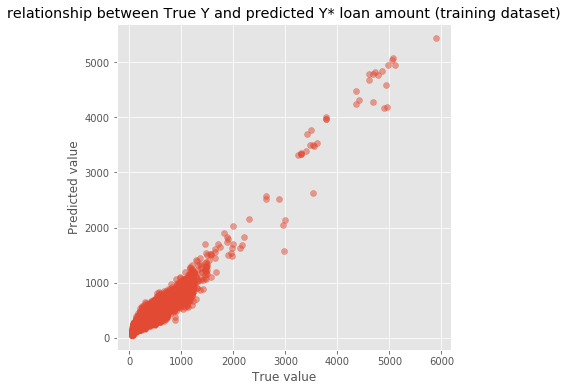

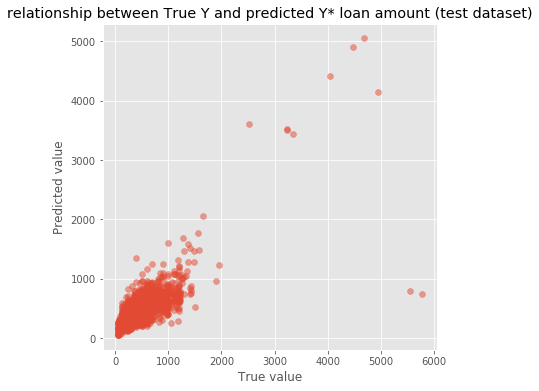

In [128]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train2),train_test = "training")
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test2),train_test = "test")

Before we move onto homework, remember to output your final dataframe so you don't have to rerun it.

In [473]:
df.to_csv(data_path+'df_module_3-2.csv')

# Homework

## Predicting Days to Fund

Repeat the BaggingRegressor and the RandomForestRegressor method with a new target feature: days_to_fund. Determine the monst important features and discuss which features are intuitive or a surprise and why. 


In [129]:
y = df['days_to_fund']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('days_to_fund', axis=1)

In [130]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [ ]:
# Use the BaggingRegressor method to predict the days_to_fund

In [ ]:
# Use the RandomForest Regressor method to predict the days_to_fund

In [ ]:
# Find the most important features

## Advanced Homework (optional)

The sklearn RandomForest library also has a classifier method, which rather than predicting a continuous numerical value such as loan amount or days to fund, it attempted to classify data on existing labels, eg: male or female. 

We imported this method at the beginning and you can read more about it here using the following cell or by going the sklearn [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) webpage.

In [148]:
RandomForestClassifier?

Using this module and the original feature gender, see how well we can classify loans by the gender. The procedure for training and testing data is practically the same as the RandomForestRegressor and the score is the mean accuracy of the predictions rather than the R^2 of the regression. 

## Advanced Material: Optimising the algorithm
<a id='AdvancedCV'></a>

### K-folds example for finding optimal parameters

Firstly, lets look at how the training and test scores change as we change the depth of the tree...

In [20]:
depth_range = [2,4,6,8,10,12,14,16,18,20,22,24]
scores_train = np.zeros(len(depth_range))
scores_test = np.zeros(len(depth_range))
for i in range(len(depth_range)):
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    model = dt_regressor.fit(X_train, y_train)
    scores_train[i] = model.score(X_train, y_train)
    scores_test[i] = model.score(X_test, y_test)

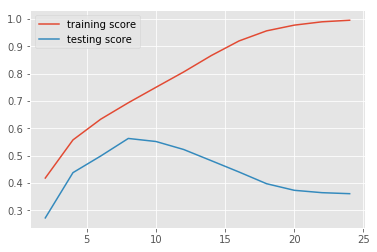

In [21]:
plt.plot(depth_range, scores_train, label='training score')
plt.plot(depth_range, scores_test, label='testing score')
plt.legend(loc='best')
plt.show()

As we increase the depth:
- The training score increases
- But the testing score decreases

Once the test score starts decreasing, this indicates that the model is overfitting. 

Here we could be tempted to say that the optimal depth is approximately 8 as this corresponds to the maximum score for the testing data. **However this is not the case**. The test set is just random fixed subset of data so choosing the optimal parameter here would be overfitting to the testset. 

This is where K-Folds cross validation comes in! This method does the following:
- Splits the dataset K equal random subsests
- Trains the data on K-1 subsets
- Evaluates performance on Kth left out subset
- Stores evaluation metric
- Repeats for K times for each random subset

Therefore if K = 5, the algorithm trains 5 times. Each time it holds out a 5th of the data, trains on the other 4/5ths and then evaluates the performance on the held out 5th. 

Here is an example of how the cross validation score changes with maximum tree depth

In [24]:
scores_cv = np.zeros(len(depth_range))
for i in range(len(depth_range)):
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    cv_scores = cross_val_score(dt_regressor, X_train, y_train,cv=5, n_jobs=-1)
    scores_cv[i] = np.mean(cv_scores)

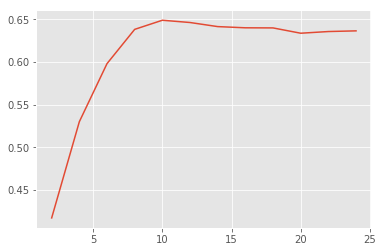

In [25]:
plt.plot(depth_range, scores)
plt.show()

Again we see the same general trend of the score increasing intially and then dropping off. However, the changes are less pronounced than above in the test dataset as we are generalising by using cross-validation. 

From this curve, the optimal max_depth would be 10. 

### GridSearchCV (CV = cross validation)

Above we were looking at a single parameter. However, to increase perfromance we should try adjusting several parameters. 

Sklearn's GridSearchCV uses the cross-validation bove to assess the performance of each possible permutation of the hyper-parameters that you specify. It then returns a model initialised with the optimal parameters.

In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor(n_jobs=-1)
grid_rf = GridSearchCV(gridrf, parameters)

In [30]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [131]:
grid_rf.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Next, let's check out the variation in performance.

In [132]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.677 (+/-0.031) for {'max_features': 'auto', 'n_estimators': 100, 'max_depth': None}
0.679 (+/-0.031) for {'max_features': 'auto', 'n_estimators': 300, 'max_depth': None}
0.678 (+/-0.030) for {'max_features': 'auto', 'n_estimators': 500, 'max_depth': None}
0.657 (+/-0.035) for {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': None}
0.660 (+/-0.037) for {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None}
0.661 (+/-0.040) for {'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': None}
0.651 (+/-0.039) for {'max_features': 'log2', 'n_estimators': 100, 'max_depth': None}
0.652 (+/-0.036) for {'max_features': 'log2', 'n_estimators': 300, 'max_depth': None}
0.650 (+/-0.042) for {'max_features': 'log2', 'n_estimators': 500, 'max_depth': None}
0.589 (+/-0.048) for {'max_features': 'auto', 'n_estimators': 100, 'max_depth': 5}
0.591 (+/-0.046) for {'max_features': 'auto', 'n_estimators': 300, 'max_depth': 5}
0.591 (+/-0.043) for {'max_features': 'auto', 'n_estimators'